# Extracting behavior from mouse face videos

### Load in mouse face videos

Using the `pyav` library, load in the first 3000 frames of this movie. It is a gray-scale movie so we only take one channel of the RGB output.

In [14]:
import av
import os
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import time
from scipy.stats import skew
from scipy.sparse.linalg import eigsh
from facemap import utils

### PUT HERE THE PATH TO THE MOVIE
root = '/home/neuraldata/data/meso/'
mouse_name = 'TX39'
moviename = os.path.join(root, mouse_name, 'cam1_TX39.avi')

container = av.open(moviename)
container.streams.video[0].thread_type = 'AUTO'
nframes = container.streams[0].duration

k=0
for frame in container.decode(video=0):
    array = frame.to_ndarray(format='rgb24')
    if k==0:
        imgs = np.zeros((3000, array.shape[0], array.shape[1]), np.uint8)
    # take one channel of the data
    imgs[k] = array[:,:,0]
    k+=1
    if k==3000:
        break
    

### Compute the motion energy

To understand behavior, we do not necessarily care where the mouse's whisker is - rather we care how it moved. We compute movements by taking the difference between frames. Then we take the absolute value of this because we want overall movement, regardless of sign. This absolute value of the difference is the **motion energy**.

In [15]:
# motion energy
motion = np.abs(np.diff(imgs.astype(np.float32), axis=0))

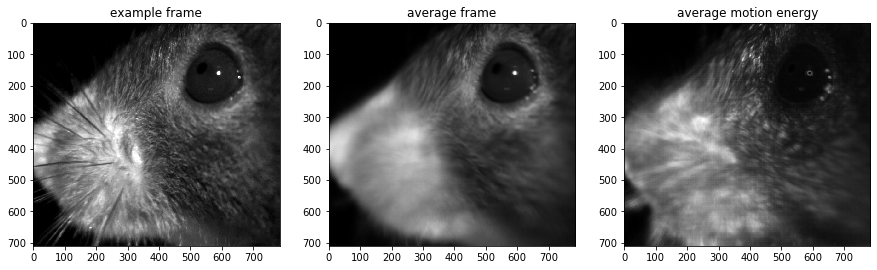

In [16]:
# plot of frames

fig = plt.figure(figsize=(15,5))

# example frame
ax=fig.add_subplot(1,3,1)
ax.imshow(imgs[100], cmap=plt.get_cmap('gray'))
ax.set_title('example frame')

# average mouse face
ax=fig.add_subplot(1,3,2)
ax.imshow(imgs.mean(axis=0), cmap=plt.get_cmap('gray'))
ax.set_title('average frame')

# average motion energy
ax=fig.add_subplot(1,3,3)
ax.imshow(motion.mean(axis=0), cmap=plt.get_cmap('gray'))
ax.set_title('average motion energy')

plt.show()

### Reduce dimensionality of motion energy

Motion energy is dimensionality number of frames by number of pixels. We want to only keep the top 100 principal components of this motion energy. Let's compute the top 100 spatial components of the data.

In [17]:
motion = np.reshape(motion, (motion.shape[0],-1))
motion -= motion.mean(axis=0)

# take the principal components of these mean-centered motion energy frames
from sklearn.decomposition import PCA
ncomps = 100
pca = PCA(n_components=ncomps).fit(motion)

print('spatial components of size (%d, %d)'%pca.components_.shape)

spatial components of size (100, 556640)


We can plot these spatial components. Observe that most of the variation occurs in the whisker pad.

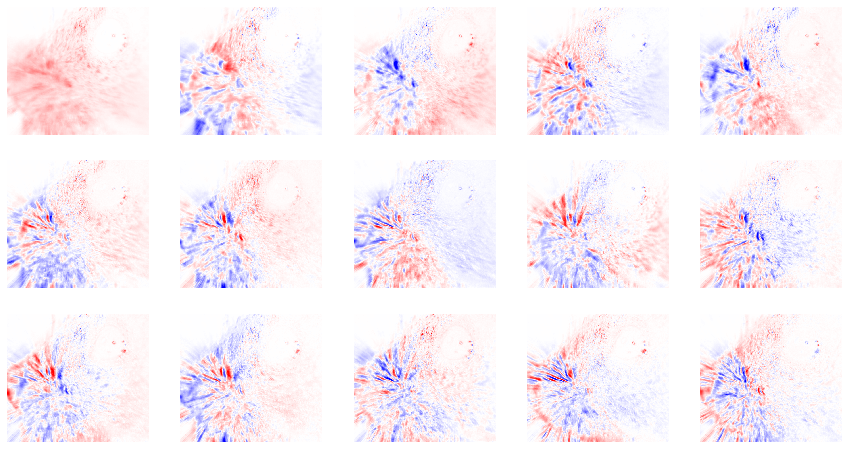

In [18]:
Ly,Lx=imgs.shape[1:]
motMask = np.reshape(pca.components_, (-1, Ly, Lx))
plt.figure(figsize=(15,8))
for i in range(15):
    ax=plt.subplot(3,5,i+1)
    ax.imshow(motMask[i], cmap='bwr', vmin=-.01, vmax=0.01)
    ax.axis('off')
plt.show()

### Project spatial components onto all frames

To compute the low-dimensional representation of the motion energy across time, we need to now PROJECT these spatial components onto the the motion energy for each frame.

The principal components are the same as the $U$ in singular value decomposition, where the singular value decomposition is
$$ X \approx USV^\top $$

Let's multiply $U^\top$ on both sides, recall that $U U^\top = I$ because $U$ is an orthonormal matrix.
$$ U^\top X = S V^\top $$

So $U^\top X$ gives the right singular vectors scaled by the variance of each component. We will use this instead of using $S^{-1} U^\top X$. Why might we want them to be weighted by their true variance in the video?

In [19]:
### HOW DO THESE SPATIAL COMPONENTS VARY IN TIME?
motSVD = pca.components_ @ motion.T

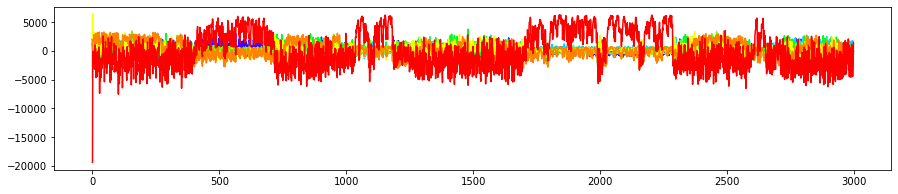

In [22]:
# PLOT TRACES

plt.figure(figsize=(15,3))
# flip traces
motSVD *= np.sign(skew(motSVD, axis=1))[:,np.newaxis]
cmap = cm.get_cmap('hsv')
cmap = cmap(np.linspace(0,.8,10))
for n in range(10):
    plt.plot(motSVD[n], color=cmap[n],zorder=10-n)
plt.show()